# Real-Time Optimization
## Modifier Adaptation with Bayesian Optimization using EIC acquisition
### Preliminary thesis results

In [2]:
# Loading the necessary packages
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.utils import Bunch
from os.path import join

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"
plt.rcParams["savefig.dpi"] = 300

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.basicConfig(level=logging.ERROR)

from rto.models.williams_otto import WilliamsOttoReactor, WilliamsOttoReactorSimplified
from rto.optimization.optimizer import ModifierAdaptationOptimizer, ModelBasedOptimizer
from rto.optimization.bayesian import ModelBasedBayesianOptimizer
from rto.rto import RTOBayesian, RTO
from rto.adaptation.ma_gaussian_processes import MAGaussianProcesses
from rto.utils import generate_samples_uniform
from rto.experiment.analysis import ExperimentAnalyzer

#DATABASE = "/mnt/d/rto_data/thesis-analysis-08.db"
DATABASE = "/mnt/d/rto_data/final-results-wo.db"

FIGURES_PATH = None# "/mnt/d/textos-mestrado/dissertacao/figures/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis

The real process will be called the "plant", while the uncertain one is the "model". First, we create and instance for each one:

In [3]:
# Our complete model will be called the "plant"
plant = WilliamsOttoReactor()
# And the uncertain is the "model"
model = WilliamsOttoReactorSimplified()
# define the constraints
g0 = 0.12
g1 = 0.08
ubx = [6, 100]
lbx = [3, 70]
g = np.array([g0, g1])

Next, let's have a look at the decision surface of our cost function, along with the constraints. This is a way to observe the effects of the plant-model mismatch. First we do a grid search over the input domain, storing the objective and constraint values.

In [30]:
# Define the input domain
grid_size = 50

u1 = np.linspace(3, 6, grid_size)
u2 = np.linspace(70, 100, grid_size)
xx, yy = np.meshgrid(u1, u2)

def get_grid_values(model, xx, yy, noise=None):
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost = np.array([model.get_objective(x, noise) for x in grid])
    g = np.array([model.get_constraints(x, noise) for x in grid])
    # reshape the predictions back into a grid
    zz_cost = cost.reshape(xx.shape)
    zz_g0 = g[:,0].reshape(xx.shape)
    zz_g1 = g[:,1].reshape(xx.shape)

    return zz_cost, zz_g0, zz_g1

z_plant, g0_plant, g1_plant = get_grid_values(plant, xx, yy)
z_model, g0_model, g1_model = get_grid_values(model, xx, yy)
g_plant = (g1_plant < g1)&(g0_plant < g0)
g_model = (g1_model < g1)&(g0_model < g0)

Now, the contour plot is generated for both the plant and model. The feasible region is limited by the red surface.

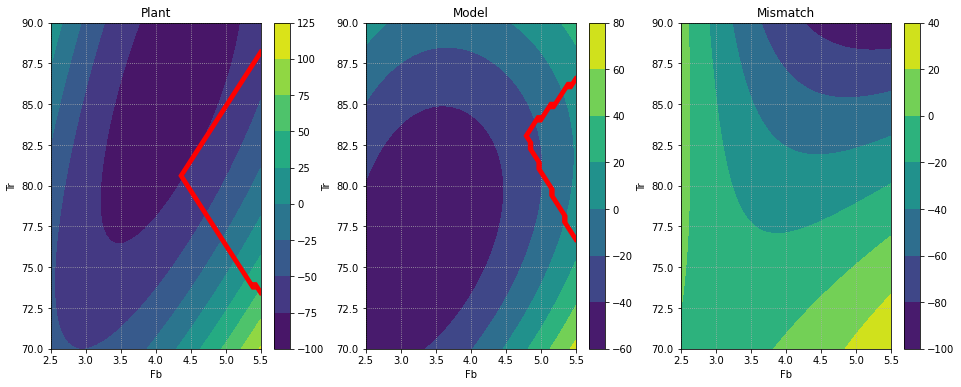

In [5]:
# Plot the decision surface
fig, ax = plt.subplots(1, 3, figsize=(16,6))
def plot_decision_surface(fig, ax, xx, yy, z_f, z_c, title, contour_type='contourf'):
    if(z_f is not None):
        ax.contour(xx, yy, z_f, colors='red')

    if(contour_type=='contourf'):
        CS = ax.contourf(xx, yy, z_c, cmap='viridis')
    else:
        CS = ax.contour(xx, yy, z_c, cmap='viridis')
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('Fb')
    ax.set_ylabel('Tr')
    ax.set_title(title)

plot_decision_surface(fig, ax[0], xx, yy, g_plant, z_plant, 'Plant')
plot_decision_surface(fig, ax[1], xx, yy, g_model, z_model, 'Model')
plot_decision_surface(fig, ax[2], xx, yy, None, z_plant - z_model, 'Mismatch')

fig.show()

From this chart we notice these interesting information:
1. The unconstrained minima of plant and model and very different. Optimizing over the model would definitely result in a sub-optimal operating point.
2. When constraints are added, the optima are located at their intersection. This could lead to unfeasible operation if optimazing over the model, if not properly evaluated beforehand.

Let's have a deeper look at item (2). In order to do that, we should solve the optimization problem described previously, for both the plant and model. The Differential Evolution algorithm will be used, because of it's nice capabilities for handling restrictions and global convergence.

In [6]:
optimizer = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de', 'params': {'strategy': 'best1bin'}}, backoff=0.0)
f_plant, u_plant ,_ = optimizer.run(plant, [])
f_model, u_model ,_ = optimizer.run(model, [])

print(f'Plant: u*={u_plant}, f*={f_plant}')
print(f'Model: u*={u_model}, f*={f_model}')

Plant: u*=[ 4.39830261 80.67065413], f*=-75.66724061399714
Model: u*=[ 4.78991726 83.19284811], f*=-26.1608030697073


Although the solution found for both the model and plant are very close, let's see what happens if we apply the input found with the model into the plant. The 'x' represents the model solution, while the "*" the plant optimum.

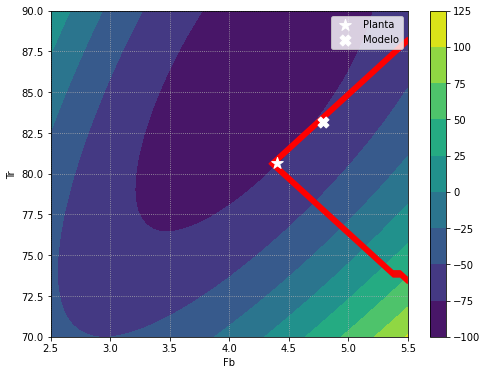

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
model_cost = plant.get_objective(u_model)

ax.scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=5)
ax.scatter(u_model[0], u_model[1], c='w', marker='X', s=120, zorder=5)
ax.legend(['Planta', 'Modelo'])

plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant,'')


fig.show()

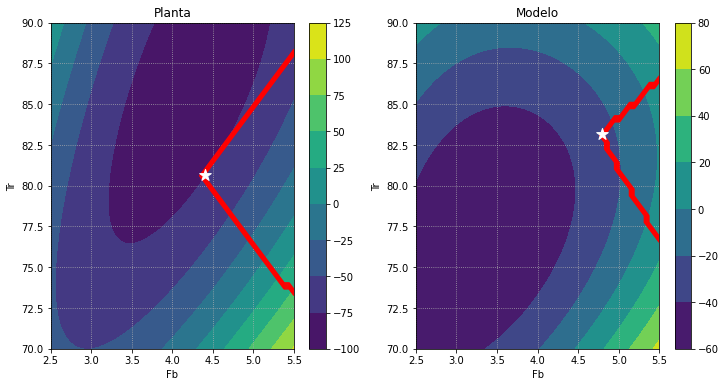

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=5)
ax[1].scatter(u_model[0], u_model[1], c='w', marker='*', s=150, zorder=5)
#ax.legend(['Planta', 'Modelo'])
plot_decision_surface(fig, ax[0], xx, yy, g_plant, z_plant, 'Planta')
plot_decision_surface(fig, ax[1], xx, yy, g_model, z_model, 'Modelo')

Notice that although the solution remained inside the feasible region, it is definitely sub-optimal. It is easy to notice that depending on the model parameters, the optimal solution could easily become unfeasible. Thus, one can see that some sort of adaptation of the model is necessary to ensure convergence to the actual plant optimum, while respecting the process constraints. 

In [9]:
# load the results
analyzer = ExperimentAnalyzer(DATABASE)
results_ma_de = analyzer.load('MA-GP-DE')
results_ma_sqp = analyzer.load('MA-GP-SQP')

results_processed_ma_de = analyzer.pre_process(results_ma_de, f_plant, u_plant)
results_processed_ma_sqp = analyzer.pre_process(results_ma_sqp, f_plant, u_plant)

results_processed_ma_de['Cenário'] = 'DE/MA-GP'
results_processed_ma_sqp['Cenário'] = 'SQP/MA-GP'

results_processed_ma_de['Amostra'] = results_processed_ma_de['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')
results_processed_ma_sqp['Amostra'] = results_processed_ma_sqp['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')

results_ma_all = pd.concat([results_processed_ma_de, results_processed_ma_sqp], ignore_index=True)

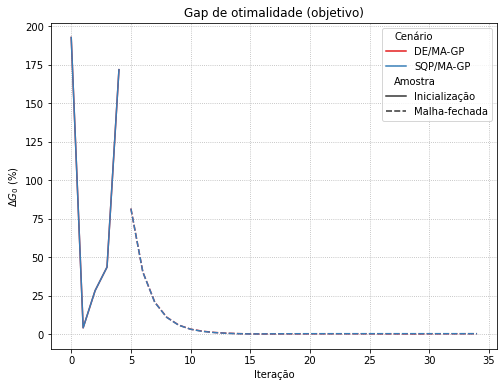

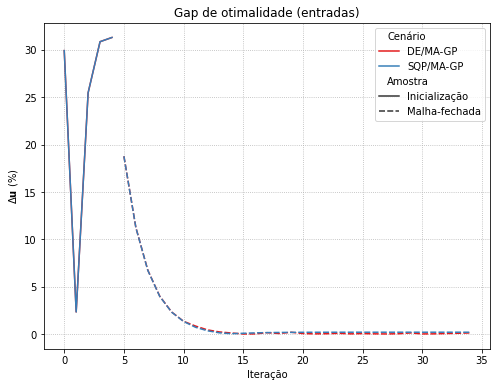

In [10]:
_, figa = analyzer.plot_by_iteration(results_ma_all, 'dPhi', '$\Delta G_0$ (%)', 'Gap de otimalidade (objetivo)',style='Amostra', hue='Cenário', xlabel='Iteração')
_, figb = analyzer.plot_by_iteration(results_ma_all, 'du', '$\Delta \mathbf{u}$ (%)', 'Gap de otimalidade (entradas)',style='Amostra', hue='Cenário', xlabel='Iteração')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'cenarioa_gap_obj.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioa_gap_u.png'))

It is also possible to look at the operating points calculated at each RTO iteration. The initial dataset is represented by the pink diamonds, while the closed-loop iterations are in black. Notice that the system rapidly converges to the plant optimum.

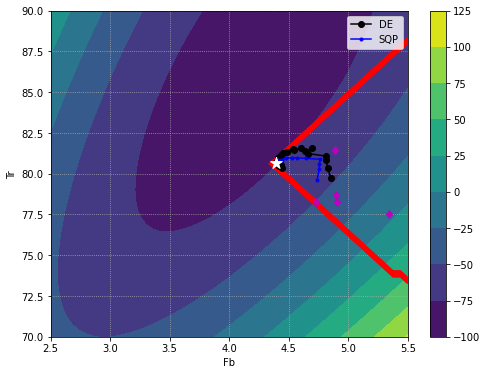

In [14]:
def plot_convergence_comparison_surface(results_1, results_2, title, legend, initial_data_size=5):
    fig, ax = plt.subplots(figsize=(8,6))

    plot_decision_surface(fig, ax, xx, yy, g_plant, z_plant, title)
    u_rto_1 = np.stack(results_1['u'], axis=0)
    u_rto_2 = np.stack(results_2['u'], axis=0)

    u_rto_init = u_rto_1[:initial_data_size, :]
    u_rto_1 = u_rto_1[initial_data_size:, :]
    u_rto_2 = u_rto_2[initial_data_size:, :]

    ax.scatter(u_plant[0], u_plant[1], c='w', marker='*', s=150, zorder=6)
    ax.plot(u_rto_init[:,0], u_rto_init[:,1], 'md', zorder=4)
    line1, = ax.plot(u_rto_1[:,0], u_rto_1[:,1], 'ko-', zorder=4)
    line2, = ax.plot(u_rto_2[:,0], u_rto_2[:,1], 'b.-', zorder=5)
    ax.legend((line1, line2), legend)

    fig.show()
    return fig, ax

fig, _ = plot_convergence_comparison_surface(results_processed_ma_de, results_processed_ma_sqp, '', ('DE','SQP'))

if FIGURES_PATH is not None:
    fig.savefig(join(FIGURES_PATH, 'cenarioa_dec_surf_obj.png'))

### Using different initial data points
We start to see more variation, but results are still equivalent for both cases. What if we initialized the system at different starting points?

In [11]:
# load the results
results_ma_de_noise_ds = analyzer.load('MA-GP-DE+noise-datasets')
results_ma_sqp_noise_ds = analyzer.load('MA-GP-SQP+noise-datasets')

results_processed_ma_de_noise_df = analyzer.pre_process(results_ma_de_noise_ds, f_plant, u_plant)
results_processed_ma_sqp_noise_df = analyzer.pre_process(results_ma_sqp_noise_ds, f_plant, u_plant)


results_processed_ma_de_noise_df['Cenário'] = 'DE/MA-GP'
results_processed_ma_sqp_noise_df['Cenário'] = 'SQP/MA-GP'

results_processed_ma_de_noise_df['Amostra'] = results_processed_ma_de_noise_df['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')
results_processed_ma_sqp_noise_df['Amostra'] = results_processed_ma_sqp_noise_df['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')

results_ma_noise_datasets_all = pd.concat([results_processed_ma_de_noise_df, results_processed_ma_sqp_noise_df], ignore_index=True)

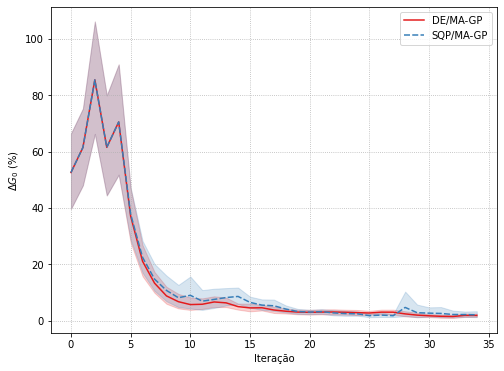

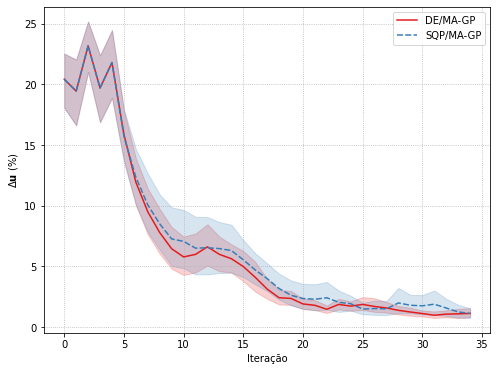

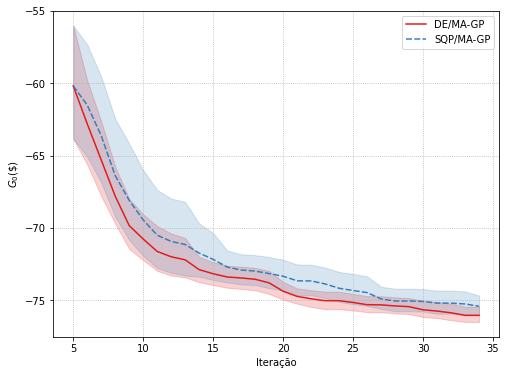

In [12]:
_, figa = analyzer.plot_by_iteration(results_ma_noise_datasets_all, 'dPhi', '$\Delta G_0$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figb = analyzer.plot_by_iteration(results_ma_noise_datasets_all, 'du', '$\Delta \mathbf{u}$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figc = analyzer.plot_by_iteration(results_ma_noise_datasets_all, 'best_plant_objective', '$G_0 (\$)$', '',style='Cenário', hue='Cenário', xlabel='Iteração')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'cenarioc_gap_obj.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioc_gap_u.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioc_best_solution.png'))

As seen in the images above, for the Williams-Otto problem, there is a very small effect on using different points for initialiazing the RTO system. Although there is some variation introduced by the measuremente noise,the system easily converges under both optimization algorithms. It is important to notice that this may not be entirely true if the problem exhibits more non-convexity, as investigated in [YY].

## EIC acquisition function

There is a clear link between RTO and Bayesian optimization. Both problems try to optimize and unknown and expensive-to-evaluate function by sampling it according to some heuristics. The main difference lies in the fact that the Bayesian framework is purely data-drive, while in RTO we have a model that, although imperfect, captures the main behavior of the unknown function. Notice that this works as some sort of *prior* knowledge, which in the Bayesian frameork could be historical samples of the function to be optimized, for example.

Considering the MA-GP scheme, one can see that the RTO system learns the plant-model mismatch using GPs and the prior knowledge of the model is used to drive plant optimization. In the Bayesian framework, this is achieved with the use of so-called acquisition functions. Therefore, one could ask the following question: what if we included the acquisition function in RTO procedure? Could this improve the system's performance? 

This was already done by [XX], which applied an EI acquisition to the objective, but used derivative-free and trust-region concepts to handle constrained problems. The idea behind this is to reduce or increase the trust-region size based on thje discrepancy between model estimations and plant measurements. But, one can clearly see that embedding a fully constrained Bayesian framework could be easily achieved. We can change the model-based optimization problem to use the EIC acquisition function, since we have GPs already trained on the constraints mismatch. This turns our constrained problem into a unconstrained one, using a barrier-like objective function.

First, let's run the optimization problem with the EIC acquisition function, using the same default parameters for GP learning. We also run MA-GP as a baseline to compare the results. The last sampled initial operating point is used to start the system. For now, only the noiseless case is considered, to avoid unexpected effects.

### Optimizer Choice

In [13]:
# load the results
analyzer = ExperimentAnalyzer(DATABASE)

results_bay_nm = analyzer.load('MA-GP-Bayesian-NM')
results_bay_de = analyzer.load('MA-GP-Bayesian-DE')
results_bay_sqp = analyzer.load('MA-GP-Bayesian-SQP')

results_processed_bay_de = analyzer.pre_process(results_bay_de, f_plant, u_plant)
results_processed_bay_sqp = analyzer.pre_process(results_bay_sqp, f_plant, u_plant)
results_processed_bay_nm = analyzer.pre_process(results_bay_nm, f_plant, u_plant)

results_processed_bay_de['Cenário'] = 'DE/MA-GP-EIC'
results_processed_bay_sqp['Cenário'] = 'SQP/MA-GP_EIC'
results_processed_bay_nm['Cenário'] = 'NM/MA-GP-EIC'

results_processed_bay_de['Amostra'] = results_processed_bay_de['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')
results_processed_bay_sqp['Amostra'] = results_processed_bay_sqp['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')
results_processed_bay_nm['Amostra'] = results_processed_bay_nm['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')

results_bayes_all = pd.concat([results_processed_bay_de, results_processed_bay_sqp, results_processed_bay_nm], ignore_index=True)

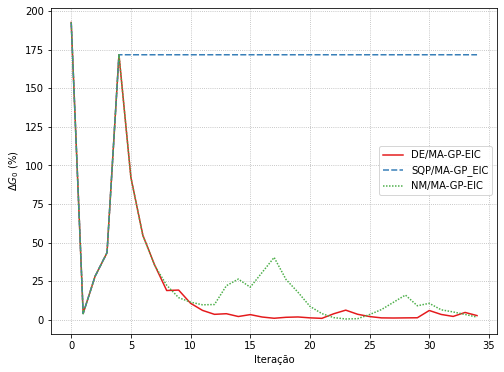

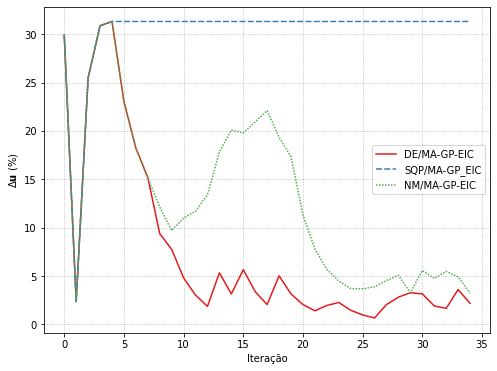

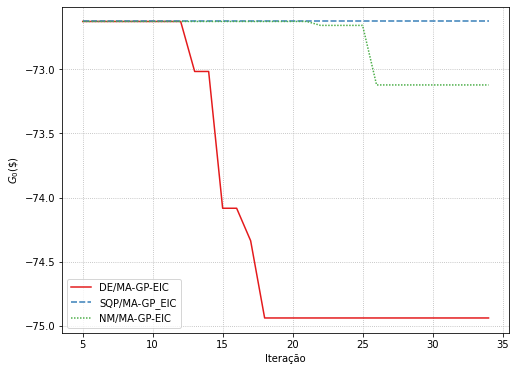

In [14]:
_, figa = analyzer.plot_by_iteration(results_bayes_all, 'dPhi', '$\Delta G_0$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figb = analyzer.plot_by_iteration(results_bayes_all, 'du', '$\Delta \mathbf{u}$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figc = analyzer.plot_by_iteration(results_bayes_all, 'best_plant_objective', '$G_0 (\$)$', '',style='Cenário', hue='Cenário', xlabel='Iteração')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'cenarioa_gap_obj_eic.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioa_gap_u_eic.png'))
    figc.savefig(join(FIGURES_PATH, 'cenarioa_best_solution_eic.png'))

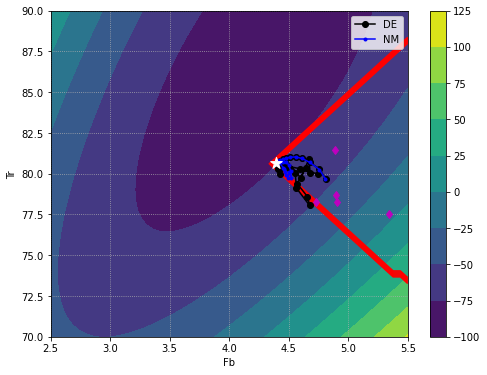

In [21]:
fig, _  = plot_convergence_comparison_surface(results_processed_bay_de, results_processed_bay_nm, '', ('DE','NM'))

if FIGURES_PATH is not None:
    fig.savefig(join(FIGURES_PATH, 'cenarioa_dec_surf_obj_eic.png'))

### Comparison with MA-GP

As seen before, SQP is unable to even find properly optimizer the EIC function. Therefore, we continue the remainder of this tutorial considering the DE algorithm as the default optimizer. Now, we comparte the results classic MA-GP scheme and with EIC acquisition function, considering the same experimental conditions.

The results for the cost and input optimality gap are displayed below. Notice that using the proposed Bayesian framework, we achieve similar results as the MA-GP baseline. However, the Bayesian approach presents more variability during the optimization steps, we could be related to the way we penalize the constraints violations. As seen previously, the optimal point will lie exactly at the intersection of two constraints, which poses a challenge for the RTO system. 

Another angle is to understand how the EIC acquisition function balances exploration and explotation. Maybe there is some exploitation happening when it shouldn't.

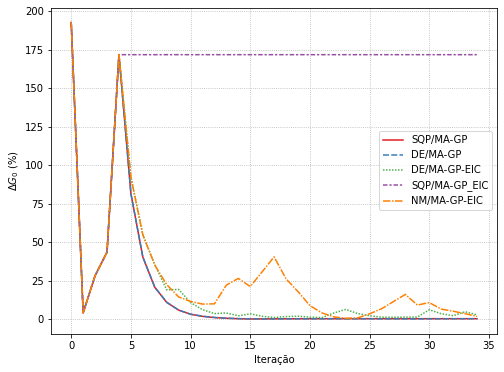

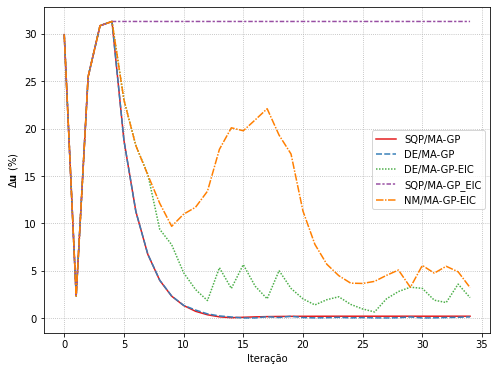

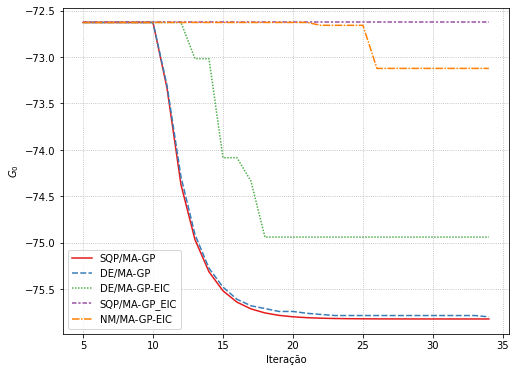

In [15]:
results_bayes_magp = pd.concat([results_processed_ma_sqp, results_processed_ma_de, results_processed_bay_de, results_processed_bay_sqp, results_processed_bay_nm], ignore_index=True)

_, figa = analyzer.plot_by_iteration(results_bayes_magp, 'dPhi', '$\Delta G_0$ (%)', '', style='Cenário', hue='Cenário', xlabel='Iteração')
_, figb = analyzer.plot_by_iteration(results_bayes_magp, 'du', '$\Delta \mathbf{u}$ (%)', '', style='Cenário', hue='Cenário', xlabel='Iteração')
_, figc = analyzer.plot_by_iteration(results_bayes_magp, 'best_plant_objective', '$G_0$', '', style='Cenário', hue='Cenário', xlabel='Iteração')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'cenarioa_gap_obj_all_wo.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioa_gap_u_all_wo.png'))
    figc.savefig(join(FIGURES_PATH, 'cenarioa_best_solution_all_wo.png'))

### Investigating the EIC decision surface

We previously saw that the proposed Bayesian framework has some variation during the RTO iterations that caused its deviation from the plant optimum. In the next analysis, we plot some of the iterations in order to understand how the algorithm is driving the optimization process. For that, the EI and EIC functions' decision surface will be investigated.

In [27]:
def get_grid_predictions(models, xx, yy):
    # unpack stuff
    fobj = models['f']
    scaler = models['gp_scaler']
    constraint0 = models['g_0']
    constraint1 = models['g_1']
    
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    cost = np.array([model.get_objective(x) + fobj.predict(scaler.transform(x.reshape(1,-1))) for x in grid])
    g_0 = np.array([model.get_constraints(x)[0] + constraint0.predict(scaler.transform(x.reshape(1,-1))) for x in grid])
    g_1 = np.array([model.get_constraints(x)[1] + constraint1.predict(scaler.transform(x.reshape(1,-1))) for x in grid])

    # reshape the predictions back into a grid
    zz_cost = cost.reshape(xx.shape)
    zz_g0 = g_0.reshape(xx.shape)
    zz_g1 = g_1.reshape(xx.shape)

    return zz_cost, zz_g0, zz_g1

def plot_gp_surface(fig, ax, xx, yy, z_f, title):
    CS = ax.contour(xx, yy, z_f)
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('Fb')
    ax.set_ylabel('Tr')
    ax.set_title(title)

def plot_gp_predictions(ax, i, gp_iterations, xx, yy, title, initial_data_size=5):
    f_gp, g0_gp, g1_gp = get_grid_predictions(gp_iterations[initial_data_size + i],xx,yy)
    g_gp = (g1_gp < g1)&(g0_gp < g0)
    plot_decision_surface(fig, ax, xx, yy, g_gp, f_gp, title)

In [27]:
def get_eic_grid(models, xx, yy, f_best):
    # unpack stuff
    fobj = models['f']
    scaler = models['gp_scaler']
    constraint0 = models['g_0']
    constraint1 = models['g_1']
    
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    ei = []
    eic = []
    g0_probs = []
    g1_probs = []

    for x in grid:
        xs = scaler.transform(x.reshape(1,-1))
        model_obj = model.get_objective(x)
        model_g = model.get_constraints(x)

        adaptation = Bunch(modifiers=[fobj.predict(xs, return_std=True), constraint0.predict(xs, return_std=True), constraint1.predict(xs, return_std=True)])
        ei_f = ModelBasedBayesianOptimizer.ei_acquisition(model_obj, adaptation, f_best)

        ei.append(ei_f)
        probs = ModelBasedBayesianOptimizer.constraint_probability(g, model_g, adaptation)
        eic.append(ei_f*np.prod(probs))
        g0_probs.append(probs[0])
        g1_probs.append(probs[1])


    # reshape the predictions back into a grid
    zz_ei = np.array(ei).reshape(xx.shape)
    zz_g0 = np.array(g0_probs).reshape(xx.shape)
    zz_g1 = np.array(g1_probs).reshape(xx.shape)
    zz_eic = np.array(eic).reshape(xx.shape)

    return zz_ei, zz_g0, zz_g1, zz_eic

def plot_eic_grid(ax, i, best_solutions, gp_iterations, xx, yy, initial_data_size=5):
    fbest = best_solutions.iloc[initial_data_size + i]
    f_gp, g0_gp, g1_gp, eic = get_eic_grid(gp_iterations[initial_data_size + i],xx,yy,fbest)
    plot_decision_surface(fig, ax[0], xx, yy, None, f_gp, 'EI')
    plot_decision_surface(fig, ax[1], xx, yy, None, g1_gp*g0_gp, '$P(G(x) <= g)$')
    plot_decision_surface(fig, ax[2], xx, yy, None, eic, 'EIC')

def plot_eic(i, results, gp_iterations, xx, yy, initial_data_size=5):
    fig, ax = plt.subplots(figsize=(10,8))
    fbest = results['best_plant_objective'].iloc[initial_data_size + i]
    _, _, _, eic = get_eic_grid(gp_iterations[initial_data_size + i],xx,yy,fbest)
    plot_decision_surface(fig, ax, xx, yy, None, eic, 'EIC')
    ax.scatter(u_plant[0], u_plant[1], c='r', marker='*', s=150, zorder=6)
    u_eic = results['u_opt'].iloc[initial_data_size + i]
    ax.scatter(u_eic[0], u_eic[1], c='r', marker='x', s=150, zorder=6)
    return fig, ax

def plot_eic_iterations(iterations, results, gp_models, initial_data_size=5):
    for i, itertrain in enumerate(iterations):
        fig, ax = plt.subplots(1,3,figsize=(20,6))
        plot_eic_grid(ax, itertrain, results['best_plant_objective'], gp_models,xx,yy)

        u_eic = results['u_opt'].iloc[initial_data_size + itertrain]
        
        ax[0].scatter(u_plant[0], u_plant[1], c='r', marker='*', s=150, zorder=6)
        ax[1].scatter(u_plant[0], u_plant[1], c='r', marker='*', s=150, zorder=6)
        ax[2].scatter(u_plant[0], u_plant[1], c='r', marker='*', s=150, zorder=6)

        ax[1].scatter(u_eic[0], u_eic[1], c='r', marker='x', s=150, zorder=6)
        ax[2].scatter(u_eic[0], u_eic[1], c='r', marker='x', s=150, zorder=6)

        fig.suptitle(f'Iteração: {itertrain}')
        fig.show()

        if FIGURES_PATH is not None:
            fig.savefig(join(FIGURES_PATH, f'iter{itertrain}_dec_surf_eic.png'))

In [25]:
# generate the results
gp_results_bay_de = [analyzer.load_run_models(run_id) for run_id in results_processed_bay_de['run.id']]
gp_results_bay_sqp = [analyzer.load_run_models(run_id) for run_id in results_processed_bay_sqp['run.id']]

#### First iteration

When the RTO is started, the Bayesian problem has the following shape. In this step, there is only knowledge of the random initialization points, meaning our knowledge about the system limited. If we considered the EI function only, notice that we would find a solution that is very close to unconstrained optimum. Since we need to add the constraints, we change its shape entirely, leading to the EIC function in the last subplot. We start observing these properties:

1. With very limited knowledge of the system, the Bayesan approach is able to have a good description of both the objective and constraints. However, as seen in zoomed in chart, the EIC optimum is still far from the actual plant optimum.
2. The problem becomes much harder to be solved, and we start seeing extra non-convexity. Increasing the chart scale, notice the EIC shape compelxity and that outside this region, the problem is mostly flat. This is definitely troublesome for deterministic algorithms, since we are very likely to get stuck if initialized at the flat area. This probably explains why the SQP algorithm was unable to drive the RTO system to new solutions.

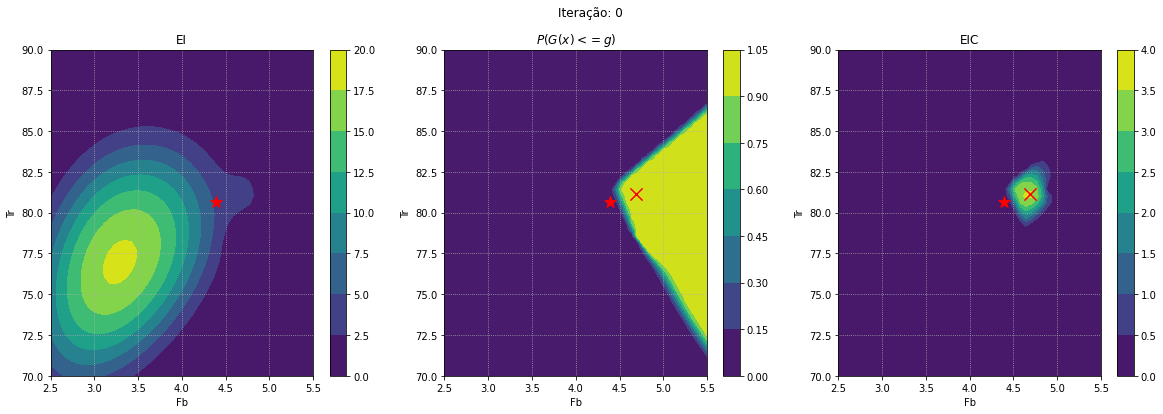

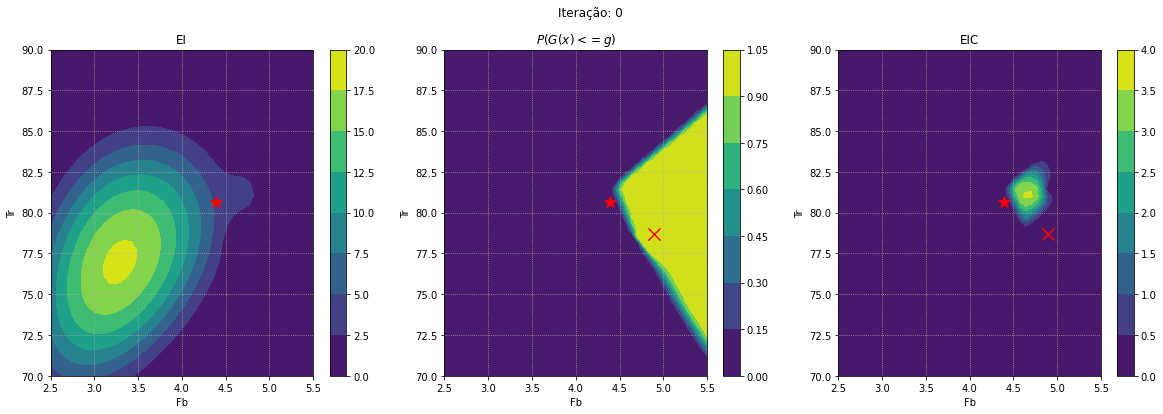

In [23]:
plot_eic_iterations([0], results_processed_bay_de, gp_results_bay_de)
plot_eic_iterations([0], results_processed_bay_sqp, gp_results_bay_sqp)

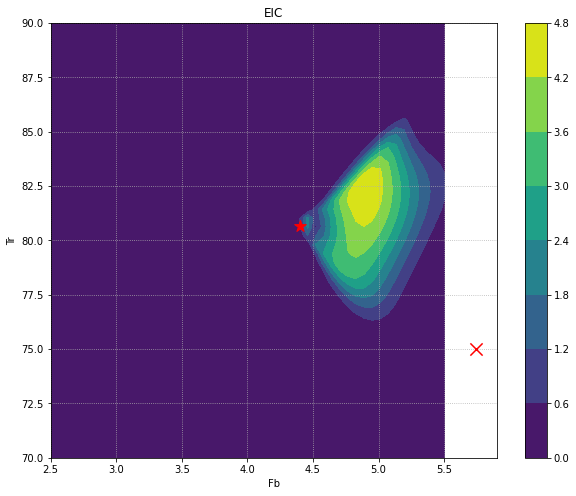

In [28]:
# zoom into the EIC function
u1_eic = np.linspace(4.2, 5.2, grid_size)
u2_eic = np.linspace(79, 84, grid_size)
xx_eic, yy_eic = np.meshgrid(u1_eic, u2_eic)

fig_eic, ax_eic = plot_eic(0, results_processed_bay_sqp, gp_results_bay_sqp, xx, yy)
if FIGURES_PATH is not None:
    fig_eic.savefig(join(FIGURES_PATH, 'zoom_iter0_dec_surf_eic.png'))

Given this backgound, we analyze next some of the other solutions found by the RTO system. Some key iterations were selected, based on the previous charts.

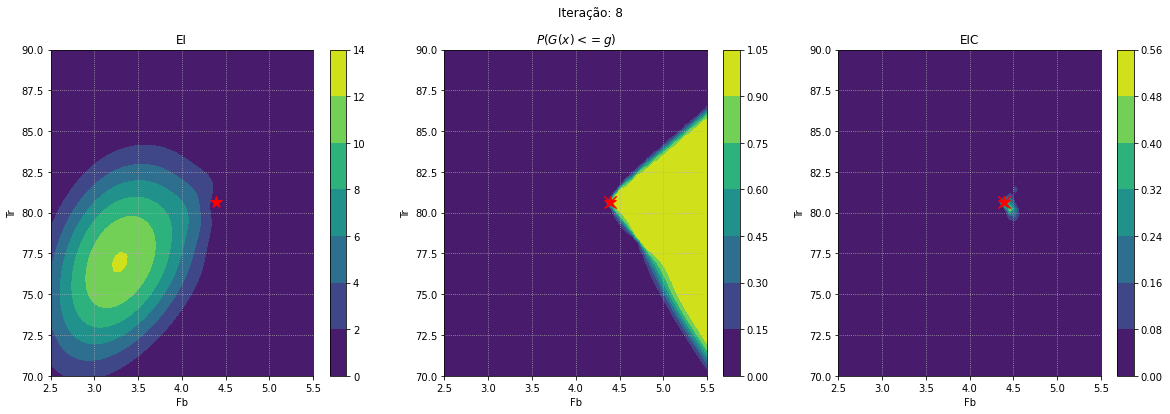

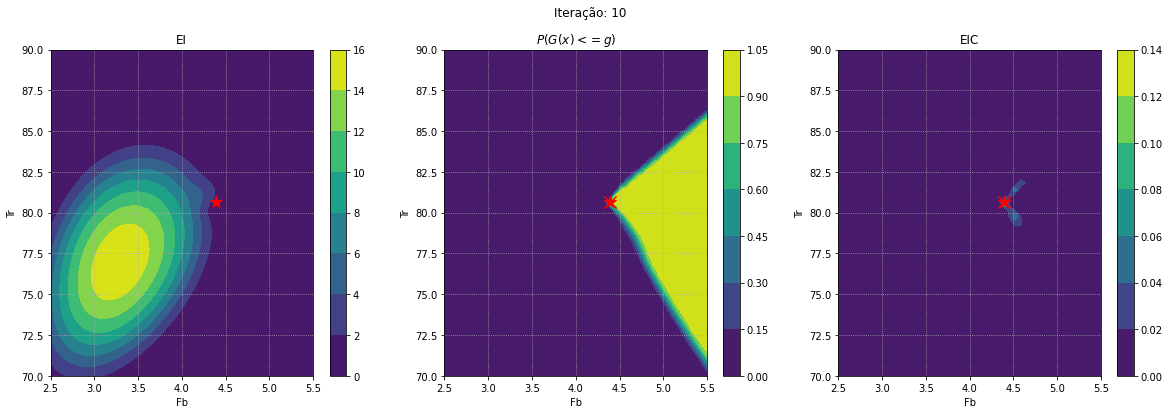

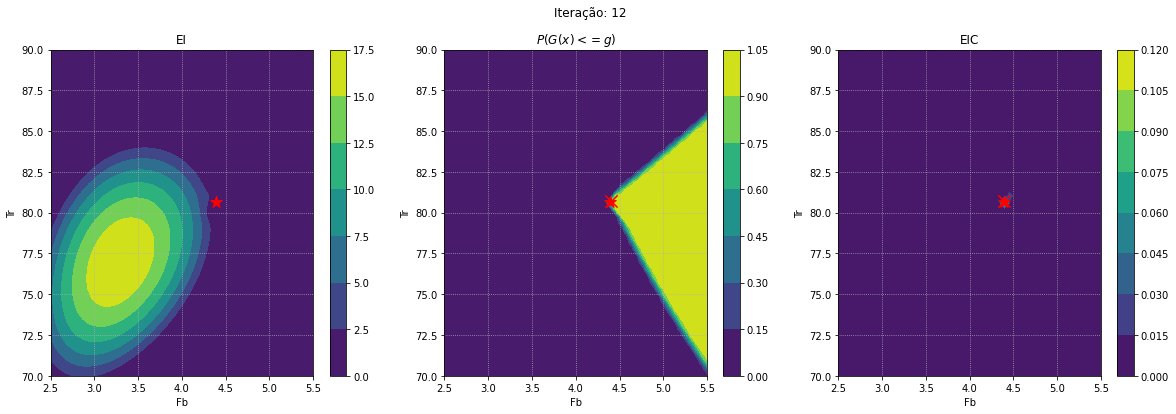

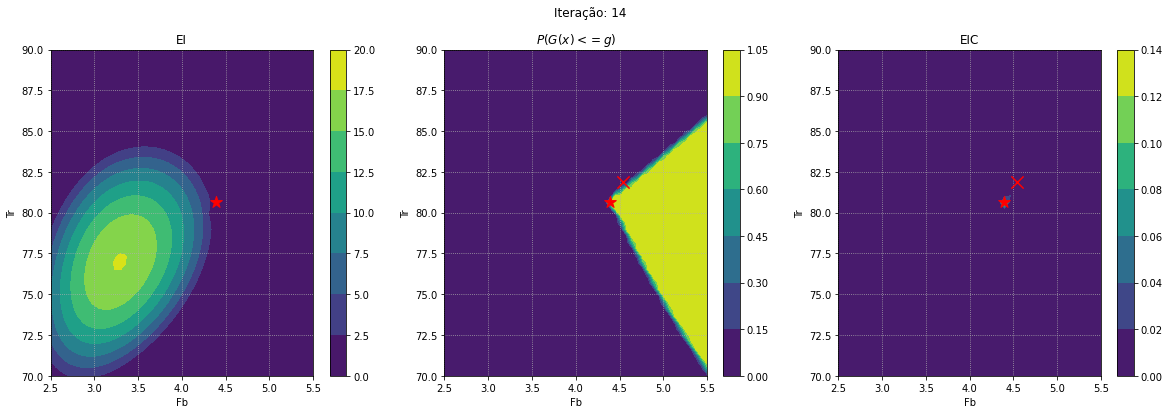

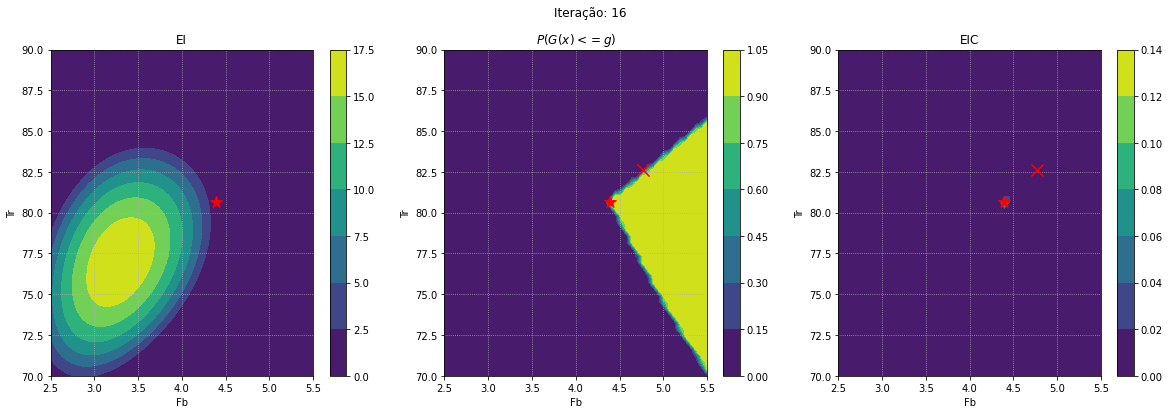

In [68]:
iterations = [8,10,12,14,16]
plot_eic_iterations(iterations, results_processed_bay_de, gp_results_bay_de)

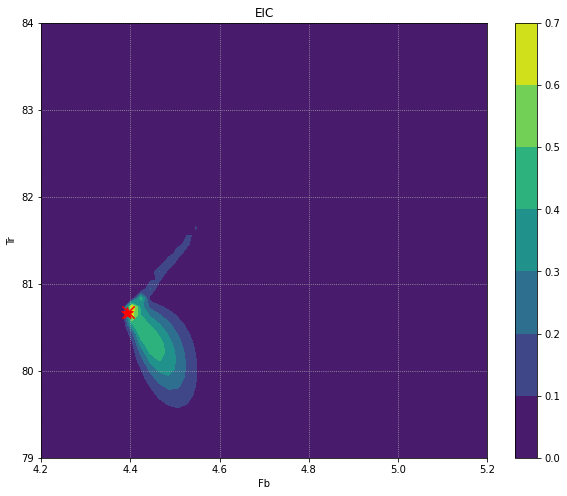

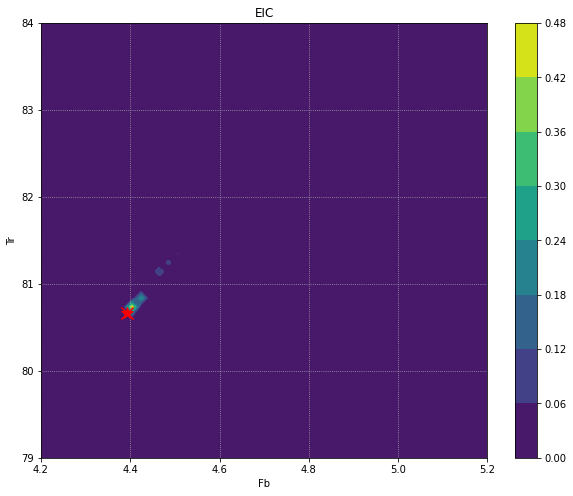

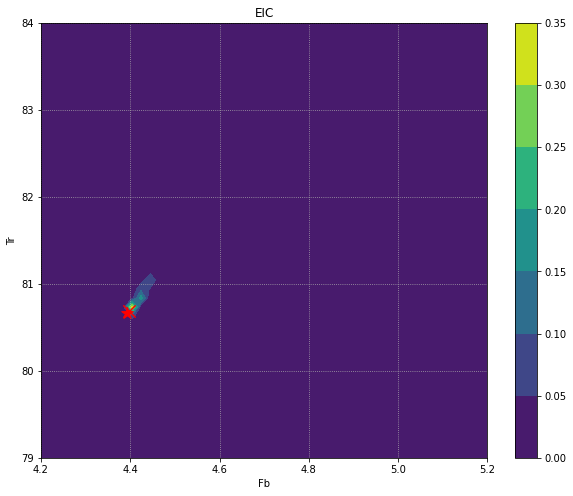

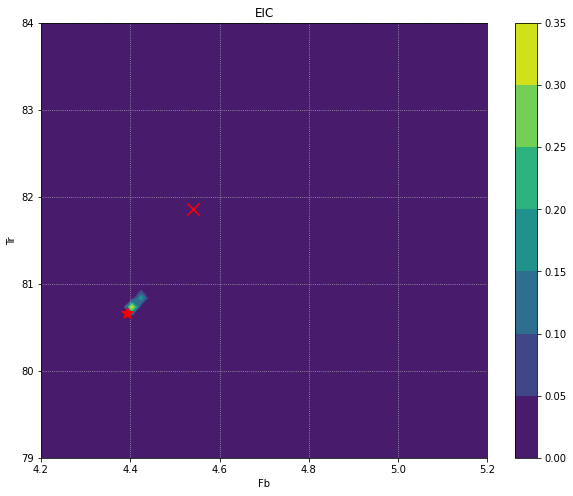

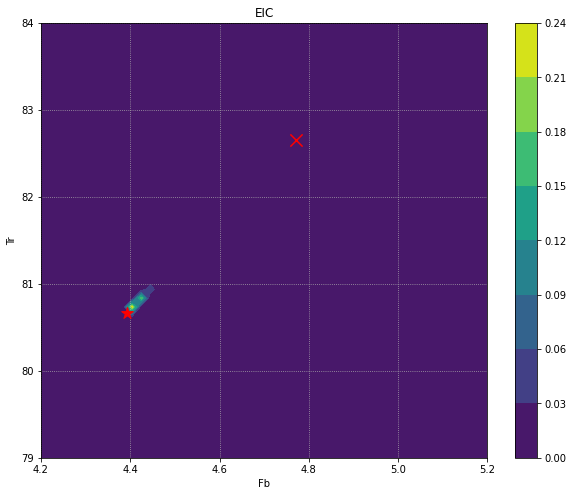

In [69]:
for it in iterations:
    fig, ax = plot_eic(it, results_processed_bay_de, gp_results_bay_de, xx_eic, yy_eic)
    if FIGURES_PATH is not None:
        fig_eic.savefig(join(FIGURES_PATH, f'zoom_iter{it}_dec_surf_eic.png'))

From the previous charts, we extract the following interesting insights:

1. On some iterations, the problem is extremely hard to solve because of its non-convexity, and even DE is unable to properly find the EIC optimum due to numerical issues. For instance, in the last iteration displayed it converges to a solution far from the optimum and we notice that a better solution remained close to the plant optimum, but it is basically a point. This would be very hard to find, requiring a lot of computational effort and also adjustment of its parameters.
2. It is also possible in some iterations that the EIC function is mostly flat, meaning there is not actually a good improvement over the entire search space. This suggests some improvements of the algorithm into this direction, as the solution will be a random point and can probably degrade the system performance.
3. A question that arises immediately is: why does the Bayesian approach can come close to the plant optimum, but does not converge like MA-GP? It we analyze the EIC function, we notice that once we are close the optimum, there is not much improvement over the objective function, and an exploration of the feasible region is favored over exploitation, since it adds more information. This is a know property of the Bayesian framework, and we can spot some iterations where we actually gain more understanding of unexplored areas near the constraints.

If the target is to converge the RTO to the plant optimum as quickly as possible, then the proposed Bayesian approach needs a better way to control the exploitation. However, this exploitation approach can be benefitial depending on the problem properties. For instance, if we had disjoint feasible regions containing an optimal and sub-optimal solution. Would MA-GP be able to properly find the global optimum if initialized at a local one?  Would tge Bayesian exploitation approach be able to leverage its exploitation behavior in that scenario?


### Effect of initialization point EIC

As a last experiment, we analyze how the choice of initial operating points could affect the EIC RTO performance. The same initial points from the MA-GP experiment are used, and both approaches are compared.

In [16]:
analyzer = ExperimentAnalyzer(DATABASE)
results_bay_datasets_de = analyzer.load('MA-GP-Bayesian-DE+noise-datasets')
results_bay_datasets_nm = analyzer.load('MA-GP-Bayesian-NM+noise-datasets')

results_bay_processed_datasets_de = analyzer.pre_process(results_bay_datasets_de, f_plant, u_plant)
results_bay_processed_datasets_nm = analyzer.pre_process(results_bay_datasets_nm, f_plant, u_plant)

results_bay_processed_datasets_de['Cenário'] = 'DE/MA-GP-EIC'
results_bay_processed_datasets_nm['Cenário'] = 'NM/MA-GP-EIC'

results_bay_processed_datasets_de['Amostra'] = results_bay_processed_datasets_de['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')
results_bay_processed_datasets_nm['Amostra'] = results_bay_processed_datasets_nm['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')

results_bayes_datasets = pd.concat([results_bay_processed_datasets_de, results_bay_processed_datasets_nm], ignore_index=True)
results_bayes_magp_datasets = pd.concat([results_processed_ma_de_noise_df, results_bay_processed_datasets_de], ignore_index=True)

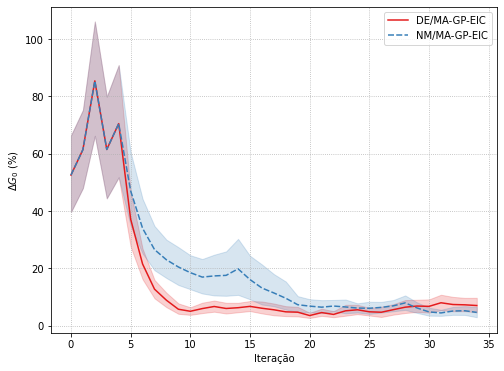

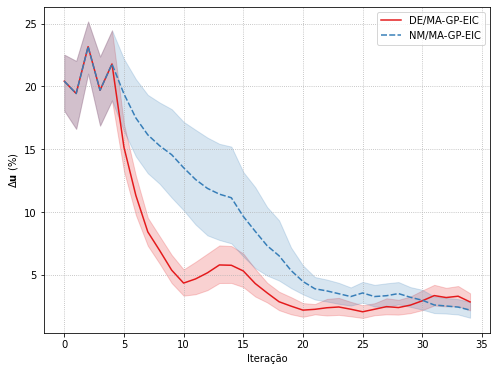

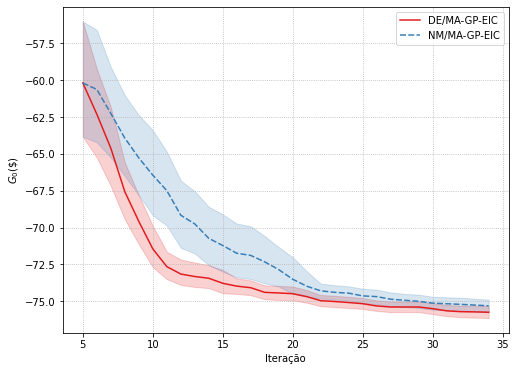

In [17]:
_, figa = analyzer.plot_by_iteration(results_bayes_datasets, 'dPhi', '$\Delta G_0$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figb = analyzer.plot_by_iteration(results_bayes_datasets, 'du', '$\Delta \mathbf{u}$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figc = analyzer.plot_by_iteration(results_bayes_datasets, 'best_plant_objective', '$G_0 (\$)$', '',style='Cenário', hue='Cenário', xlabel='Iteração')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'cenarioc_gap_obj_eic_wo.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioc_gap_u_eic_wo.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioc_best_solution_eic_wo.png'))

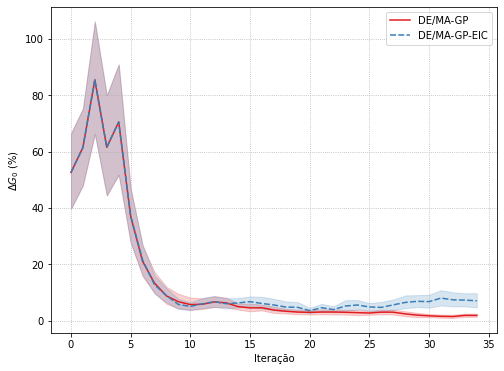

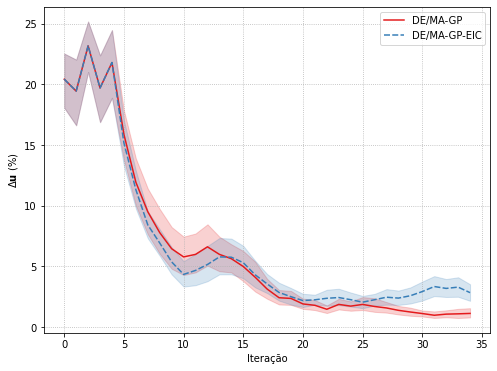

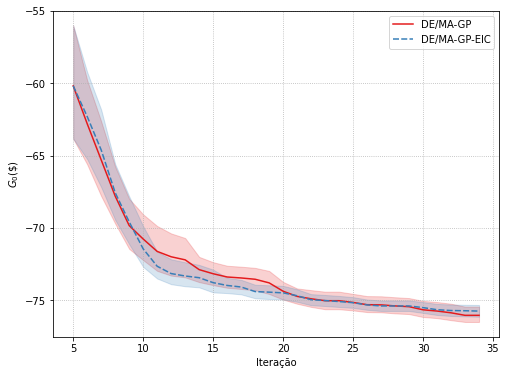

In [18]:

_, figa = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'dPhi', '$\Delta G_0$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figb = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'du', '$\Delta \mathbf{u}$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figc = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'best_plant_objective', '$G_0 (\$)$', '',style='Cenário', hue='Cenário', xlabel='Iteração')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'cenarioc_gap_obj_eic.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioc_gap_u_eic.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioc_best_solution_eic.png'))

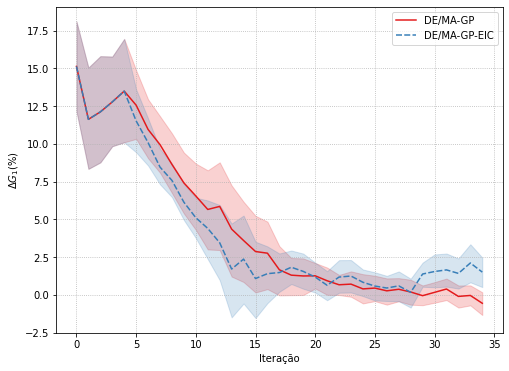

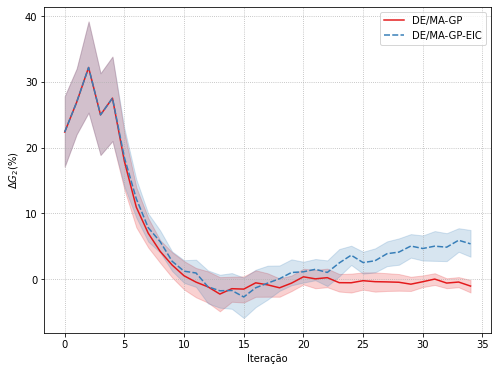

In [19]:
results_bayes_magp_datasets['dg0'] = results_bayes_magp_datasets[['g_0']].apply(lambda x: 100 * ((g[0] - x)/g[0]))
results_bayes_magp_datasets['dg1'] = results_bayes_magp_datasets[['g_1']].apply(lambda x: 100 * ((g[1] - x)/g[1]))
results_bayes_magp_datasets['dg'] = results_bayes_magp_datasets[['g_0','g_1']].apply(lambda x: 100 * np.linalg.norm((x - g)/g), axis=1)

axa, figa = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'dg0', '$\Delta G_1 (\%)$', '',style='Cenário', hue='Cenário', xlabel='Iteração')
axb, figb = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'dg1', '$\Delta G_2 (\%)$', '',style='Cenário', hue='Cenário', xlabel='Iteração')

# axa, figa = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'g_0', '$G_1^p$', '',style='Amostra', hue='Cenário', xlabel='Iteração')
# axb, figb = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'g_1', '$G_2^p$', '',style='Amostra', hue='Cenário', xlabel='Iteração')

# axa.axhline(g[0], color='black', linestyle='-')
# axb.axhline(g[1], color='black', linestyle='-')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'cenarioc_g0_eic.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioc_g1_eic.png'))

From the images above, we notice that both approaches have similar convergence behavior. There is not much difference between them regarding convergence, although one can notice that MA-GP exhibits less variation near the system convergence. This is possibly an effect of the EIC properties discussed proviously.

## Conclusion

This report shows several aspects of the MA-GP RTO problem, as well as the results of a proposed approach using constrained Bayesian optimization with the EIC acquisition function. Using the Williams-Otto reactor, we start showing how the choice of optimiation algorithm and initial points can affect the RTO performance. After that, we start analyzing the novel approach results, using the MA-GP scheme as a baseline. Interesting conclusion could be drawn from this analsys, such that:

* The EIC problem becomes non-convex and thus much harder to be solved by deterministic optimizers.
* Unnecessary exploration of the EIC acquistion leads to the degradation of the RTO performance

Therefore, as a next step, we aim to investigate different instances of the Williams-Otto problem, specially with non-convex feasible regions. This is a way to validate the limits of MA-GP, and also if the EIC exploration can become a valuable property under this situation.

## Time analsys

In [20]:
import seaborn as sns

def plot_execution_costs(data, suffix):
    figa, axa = plt.subplots(1, 1, figsize=(8, 6))
    figb, axb = plt.subplots(1, 1, figsize=(8, 6))
    
    data_plot = data[data['run.status'] != 'initialization']


    sns.boxplot(y='opt_time', data=data_plot, x='Cenário', showfliers=False, ax=axa, palette='Set1')
    axa.set_ylabel('Tempo [s]')
    sns.boxplot(y='n_fev', data=data_plot, x='Cenário', showfliers=False, ax=axb, palette='Set1')
    axb.set_ylabel('# avaliações do modelo')

    if FIGURES_PATH is not None:
        figa.savefig(join(FIGURES_PATH, f'opt_time_{suffix}.png'))
        figb.savefig(join(FIGURES_PATH, f'n_fev_{suffix}.png'))

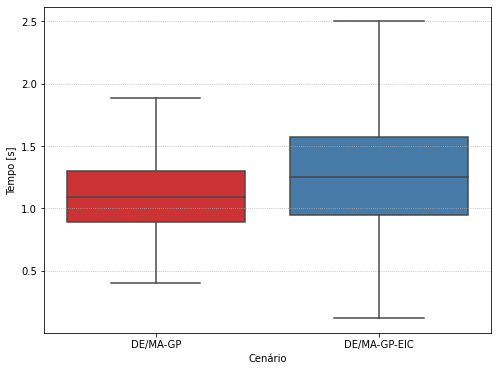

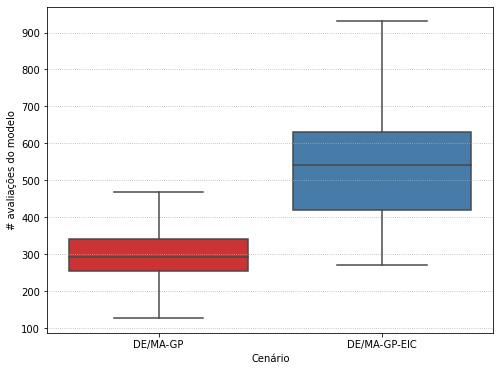

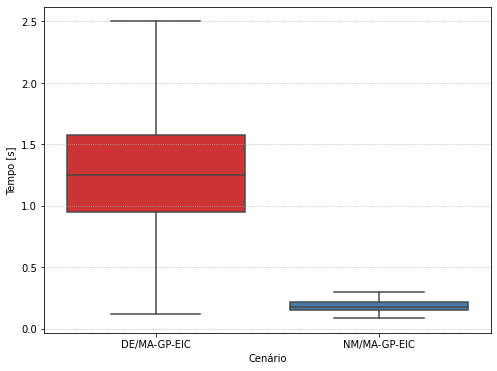

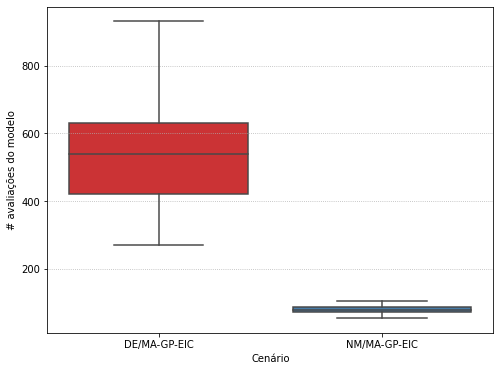

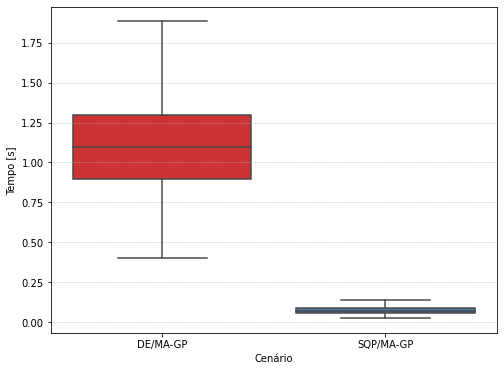

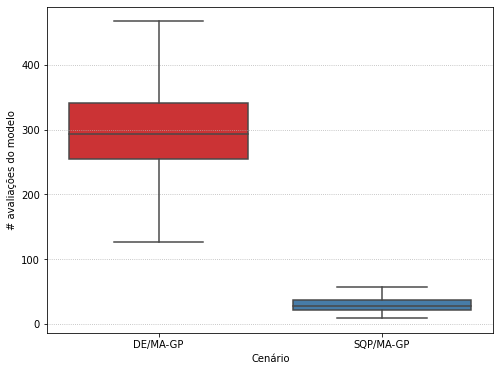

In [21]:
plot_execution_costs(results_bayes_magp_datasets, 'all_wo')
plot_execution_costs(results_bayes_datasets, 'eic_wo')
plot_execution_costs(results_ma_noise_datasets_all, 'wo')

In [23]:
results_all = pd.concat([results_processed_ma_de_noise_df, results_processed_ma_sqp_noise_df, results_bay_processed_datasets_de, results_bay_processed_datasets_nm], ignore_index=True)
results_all.where(results_all['run.status'] == 'closed-loop').groupby('Cenário')['opt_time'].agg(['mean','std','min','max']).to_latex('/mnt/d/textos-mestrado/dissertacao/tables/table_opt_time_wo.tex')

In [24]:
results_all.where(results_all['run.status'] == 'closed-loop').groupby('Cenário')['opt_time'].agg(['mean','std','min','max'])

,mean,std,min,max
Cenário,,,,
DE/MA-GP,1.119994,0.329903,0.400900,3.154598
DE/MA-GP-EIC,1.258658,0.722293,0.121937,5.369683
NM/MA-GP-EIC,0.195139,0.064643,0.087960,0.629585
SQP/MA-GP,0.087004,0.105138,0.026075,2.696490
